In [9]:
import json, cv2, numpy as np, itertools, random, pandas as pd
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
from skimage import io
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
from sklearn import model_selection
from copy import deepcopy

In [10]:
df = pd.read_csv(r'D:\CodeProject\HuBMAP2023\Data\tile_meta.csv')
df.head()

id  source_wsi  dataset      i      j
0  0006ff2aa7cd           2        2  16896  16420
1  000e79e206b7           6        3  10240  29184
2  00168d1b7522           2        2  14848  14884
3  00176a88fdb0           7        3  14848  25088
4  0033bbc76b6b           1        1  10240  43008

In [11]:
train_ids = df.query('dataset == 2')['id'].values.tolist()
valid_ids = df.query('dataset == 1')['id'].values.tolist()
print(len(train_ids), len(valid_ids))

1211 422


In [12]:
def coordinates_to_masks(coordinates, shape):
    masks = []
    for coord in coordinates:
        mask = np.zeros(shape, dtype=np.uint8)
        cv2.fillPoly(mask, [np.array(coord)], 1)
        masks.append(mask)
    return masks

def binary_mask_to_rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')
    for i, (value, elements) in enumerate(itertools.groupby(binary_mask.ravel(order='F'))):
        if i == 0 and value == 1:
            counts.append(0)
        counts.append(len(list(elements)))
    return rle

In [13]:
jsonl_file_path = r"D:\CodeProject\HuBMAP2023\Data\polygons.jsonl"
data = []
with open(jsonl_file_path, "r") as file:
    for line in file:
        data.append(json.loads(line))

coco_data = {"info": {}, "licenses": [], "categories": [], "images": [], "annotations": []}

categories = []
for item in tqdm(data, dynamic_ncols=True):
    annotations = item["annotations"]
    for annotation in annotations:
        annotation_type = annotation["type"]
        if annotation_type not in categories:
            categories.append(annotation_type)
            coco_data["categories"].append({"id": len(categories), "name": annotation_type})
            
train_coco_data = deepcopy(coco_data)
valid_coco_data = deepcopy(coco_data)

  0%|          | 0/1633 [00:00<?, ?it/s]

In [14]:
train_coco_data, valid_coco_data

({'info': {},
  'licenses': [],
  'categories': [{'id': 1, 'name': 'glomerulus'},
   {'id': 2, 'name': 'blood_vessel'},
   {'id': 3, 'name': 'unsure'}],
  'images': [],
  'annotations': []},
 {'info': {},
  'licenses': [],
  'categories': [{'id': 1, 'name': 'glomerulus'},
   {'id': 2, 'name': 'blood_vessel'},
   {'id': 3, 'name': 'unsure'}],
  'images': [],
  'annotations': []})

In [15]:
for item in tqdm(data, dynamic_ncols=True):
    image_id = item["id"]

    if image_id in train_ids:
        ds = train_coco_data
    elif image_id in valid_ids:
        ds = valid_coco_data
    else:
        raise NotImplementedError()

    image_info = {"id": image_id, "file_name": item["id"] + ".tif", "height": 512, "width": 512}
    ds["images"].append(image_info)

    for annotation in item["annotations"]:
        category_id = categories.index(annotation["type"]) + 1

        segmentation = annotation["coordinates"]
        mask_img = coordinates_to_masks(segmentation, (512, 512))[0]

        ys, xs = np.where(mask_img)
        x1, x2 = min(xs), max(xs)
        y1, y2 = min(ys), max(ys)

        rle = binary_mask_to_rle(mask_img)

        annotation_info = {
            "id": len(ds["annotations"]) + 1,
            "image_id": image_id,
            "category_id": category_id,
            "segmentation": rle,
            "bbox": [int(x1), int(y1), int(x2 - x1 + 1), int(y2 - y1 + 1)],
            "area": int(np.sum(mask_img)),
            "iscrowd": 0,
        }
        ds["annotations"].append(annotation_info)

  0%|          | 0/1633 [00:00<?, ?it/s]

In [16]:
output_file_path = r"D:\CodeProject\HuBMAP2023\Data\coco_annotations_train_all.json"
with open(output_file_path, "w", encoding="utf-8") as output_file:
    json.dump(train_coco_data, output_file, ensure_ascii=True, indent=4)
    
output_file_path = r"D:\CodeProject\HuBMAP2023\Data\coco_annotations_valid_all.json"
with open(output_file_path, "w", encoding="utf-8") as output_file:
    json.dump(valid_coco_data, output_file, ensure_ascii=True, indent=4)

loading annotations into memory...
Done (t=0.35s)
creating index...
index created!
1211


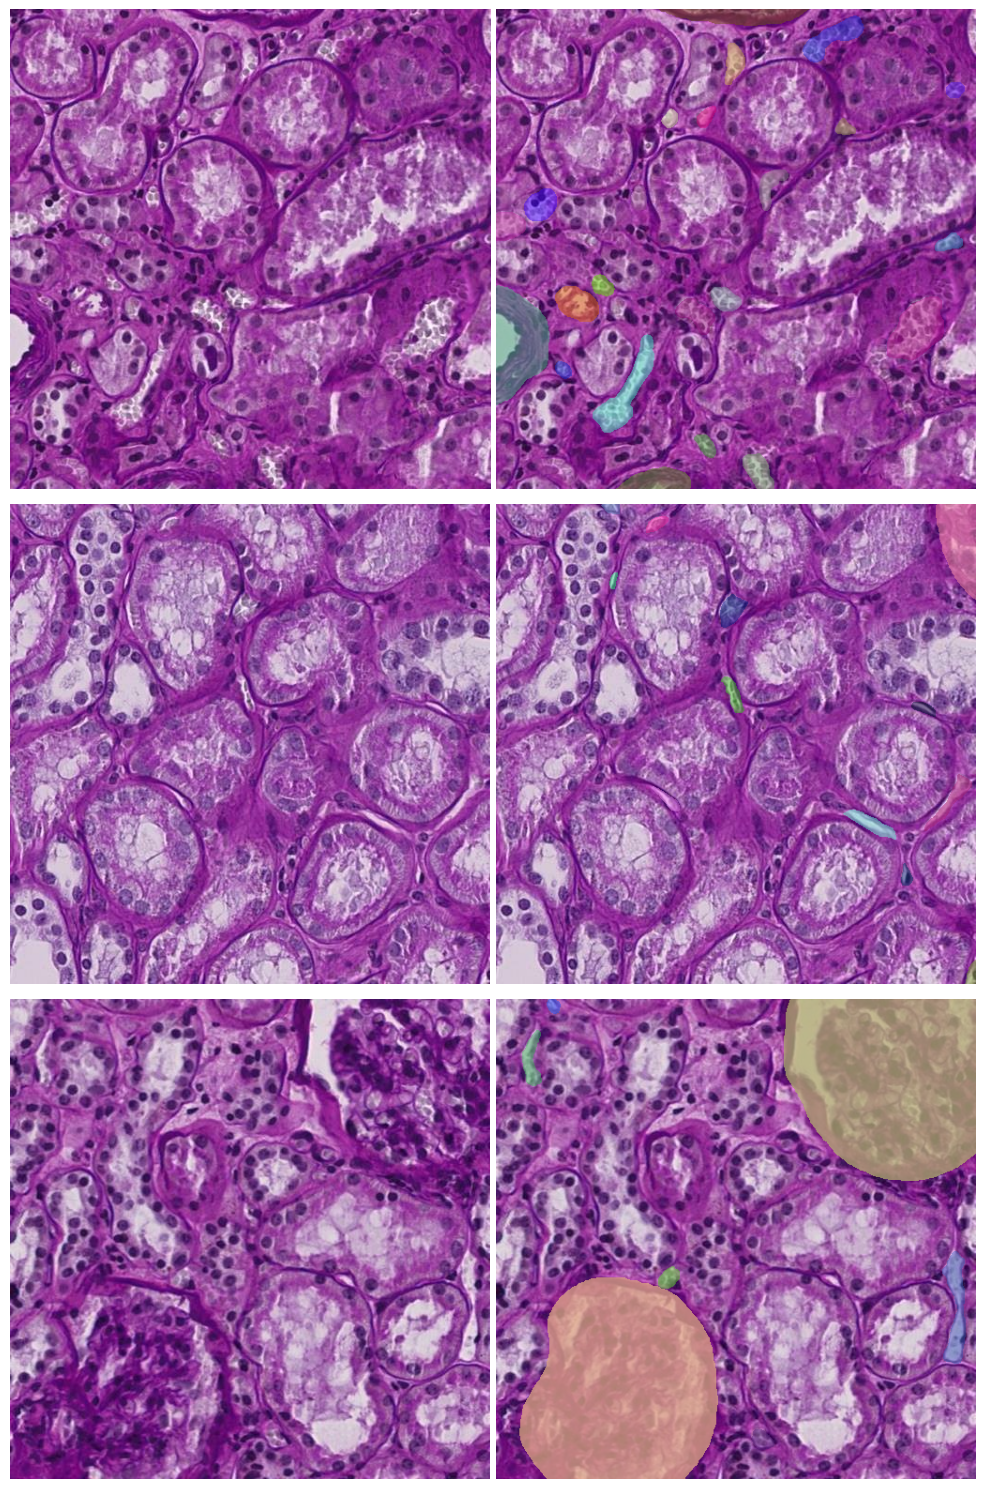

In [17]:
from PIL import Image
dataDir = Path(r"D:\CodeProject\HuBMAP2023\Data\train")
annFile = Path(r"D:\CodeProject\HuBMAP2023\Data\coco_annotations_train_all.json")
coco = COCO(annFile)

imgIds = coco.getImgIds()
print(len(imgIds))
imgs = coco.loadImgs(random.sample(imgIds, 3))

imgs = coco.loadImgs(imgIds[-3:])
fig, axs = plt.subplots(len(imgs), 2, figsize=(10, 5*len(imgs)))

# 加载图片使用 PIL
for img, ax_row in zip(imgs, axs):
    ax1, ax2 = ax_row  # 获取每行中的两个子图
    # 使用 PIL 读取图像
    I = Image.open(dataDir / img["file_name"])
    annIds = coco.getAnnIds(imgIds=[img["id"]])
    anns = coco.loadAnns(annIds)
    # 显示图片
    ax1.imshow(I)
    ax1.axis('off')
    ax2.imshow(I)
    ax2.axis('off')
    plt.sca(ax2)
    coco.showAnns(anns)
plt.tight_layout()
plt.show()

loading annotations into memory...
Done (t=0.22s)
creating index...
index created!
422


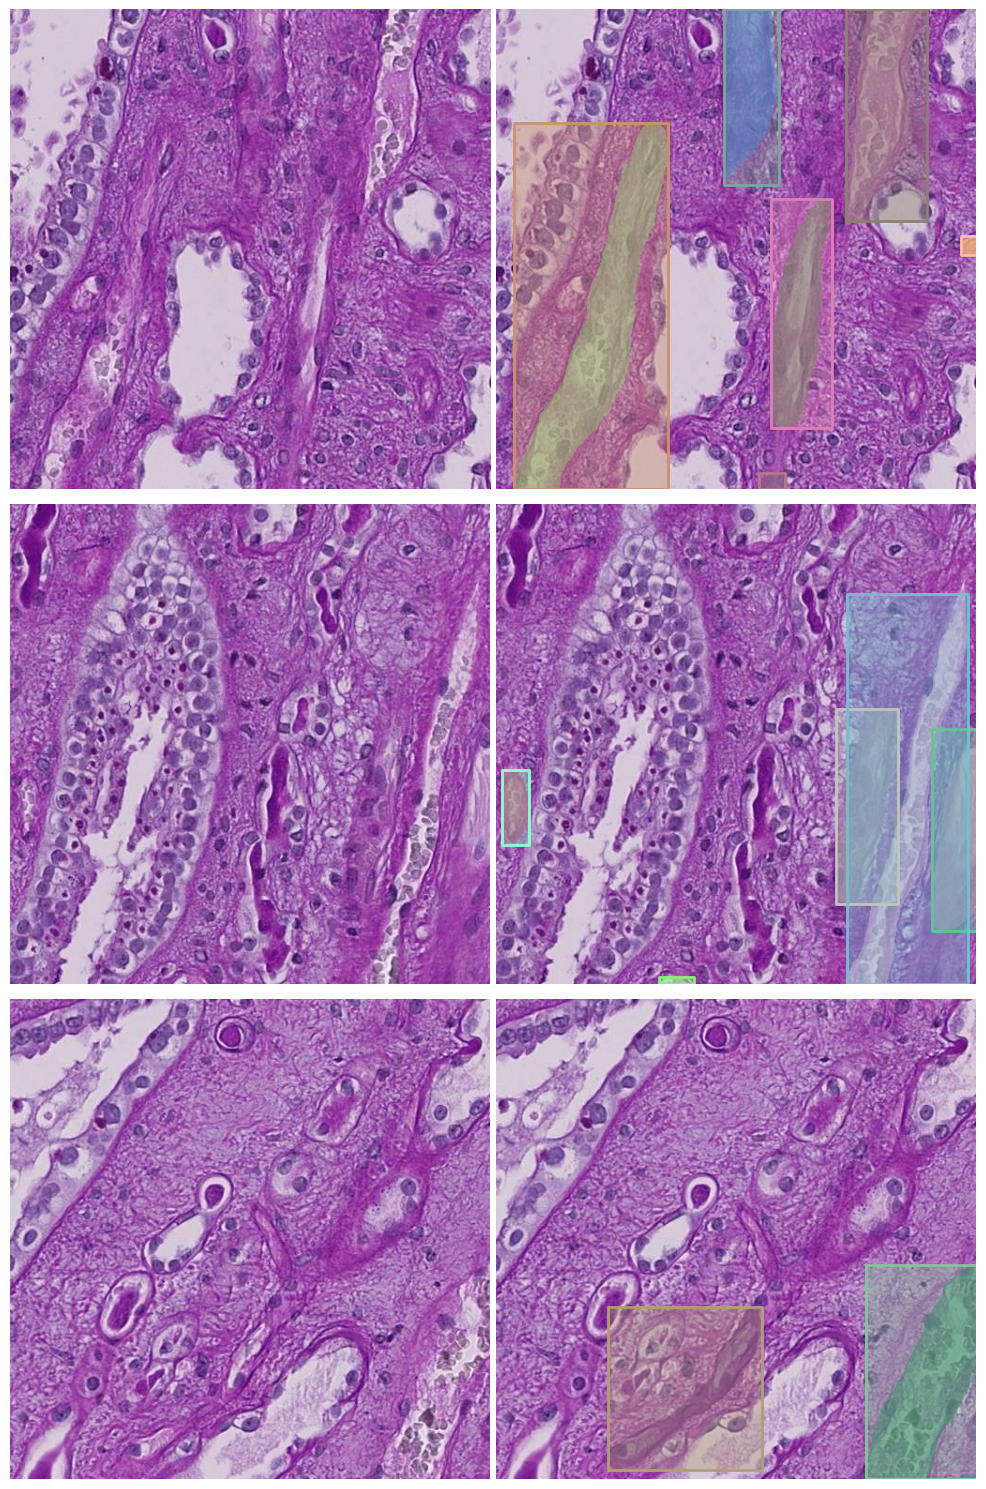

In [18]:
dataDir = Path(r"D:\CodeProject\HuBMAP2023\Data\train")
annFile = Path(r"D:\CodeProject\HuBMAP2023\Data\coco_annotations_valid_all.json")
coco = COCO(annFile)

imgIds = coco.getImgIds()
print(len(imgIds))
imgs = coco.loadImgs(random.sample(imgIds, 3))

imgs = coco.loadImgs(imgIds[-3:])
fig, axs = plt.subplots(len(imgs), 2, figsize=(10, 5*len(imgs)))

# 加载图片使用 PIL
for img, ax_row in zip(imgs, axs):
    ax1, ax2 = ax_row  # 获取每行中的两个子图
    # 使用 PIL 读取图像
    I = Image.open(dataDir / img["file_name"])
    annIds = coco.getAnnIds(imgIds=[img["id"]])
    anns = coco.loadAnns(annIds)
    # 显示图片
    ax1.imshow(I)
    ax1.axis('off')
    ax2.imshow(I)
    ax2.axis('off')
    plt.sca(ax2)
    coco.showAnns(anns, draw_bbox=True)
plt.tight_layout()
plt.show()

In [7]:
import os
import shutil
import json

# 定义源文件夹和目标文件夹
source_folder = r'D:\CodeProject\HuBMAP2023\Data\train'  # 源文件夹路径
destination_folder = r'D:\CodeProject\HuBMAP2023\Data\valid_data'  # 目标文件夹路径

# 确保目标文件夹存在
os.makedirs(destination_folder, exist_ok=True)

# 读取JSON文件
with open("D:\CodeProject\HuBMAP2023\Data\coco_annotations_valid_all.json", 'r') as file:
    data = json.load(file)

# 提取images中的file_name
if 'images' in data:
    file_names = [image['file_name'] for image in data['images']]
    print(file_names)
else:
    print("JSON中没有'images'字段。")

['0033bbc76b6b.tif', '00656c6f2690.tif', '0067d5ad2250.tif', '00d75ad65de3.tif', '00da70813521.tif', '0596bfb19322.tif', '06034408218a.tif', '06b972c417e7.tif', '072f5307f243.tif', '0754412b2917.tif', '0788fc3be62e.tif', '07bdbe578ded.tif', '089a9e6be240.tif', '093a52e9bc1d.tif', '097dd2ed6c14.tif', '0a10b8716b30.tif', '0a43459733e7.tif', '0a5be90855e3.tif', '0acd70e887b3.tif', '0b8029db1fb4.tif', '0b849dde56be.tif', '0b89ab7f9f07.tif', '0c3086bd8efb.tif', '0c54942878fa.tif', '0d6c0cfee2db.tif', '0d9d65340ef8.tif', '0dce2b8d2c25.tif', '0e0836cf1824.tif', '0e6eeb39d8f6.tif', '0e8aed930dc6.tif', '0f5b52a768e2.tif', '10162104cbaf.tif', '103906a73e6d.tif', '11128ba6d78c.tif', '1222b4306c01.tif', '12ab9ac0fc55.tif', '130d4d323ce4.tif', '13aa34ced90d.tif', '1423b40ad0dc.tif', '15e5df255b86.tif', '15ed954c0cdf.tif', '19551df15a1e.tif', '1a54cda8f32d.tif', '1a785cc0d167.tif', '1b12cccdfdd2.tif', '1bd726055ad8.tif', '1c6c39a22324.tif', '1c8af4861691.tif', '1d8aa548c370.tif', '1e0efbb8979f.tif',

In [8]:
# 遍历文件名，查找并复制文件
for file_name in file_names:
    source_file_path = os.path.join(source_folder, file_name)
    if os.path.isfile(source_file_path):
        shutil.copy(source_file_path, destination_folder)
        print(f"Copied: {file_name}")
    else:
        print(f"File not found: {file_name}")

Copied: 0033bbc76b6b.tif
Copied: 00656c6f2690.tif
Copied: 0067d5ad2250.tif
Copied: 00d75ad65de3.tif
Copied: 00da70813521.tif
Copied: 0596bfb19322.tif
Copied: 06034408218a.tif
Copied: 06b972c417e7.tif
Copied: 072f5307f243.tif
Copied: 0754412b2917.tif
Copied: 0788fc3be62e.tif
Copied: 07bdbe578ded.tif
Copied: 089a9e6be240.tif
Copied: 093a52e9bc1d.tif
Copied: 097dd2ed6c14.tif
Copied: 0a10b8716b30.tif
Copied: 0a43459733e7.tif
Copied: 0a5be90855e3.tif
Copied: 0acd70e887b3.tif
Copied: 0b8029db1fb4.tif
Copied: 0b849dde56be.tif
Copied: 0b89ab7f9f07.tif
Copied: 0c3086bd8efb.tif
Copied: 0c54942878fa.tif
Copied: 0d6c0cfee2db.tif
Copied: 0d9d65340ef8.tif
Copied: 0dce2b8d2c25.tif
Copied: 0e0836cf1824.tif
Copied: 0e6eeb39d8f6.tif
Copied: 0e8aed930dc6.tif
Copied: 0f5b52a768e2.tif
Copied: 10162104cbaf.tif
Copied: 103906a73e6d.tif
Copied: 11128ba6d78c.tif
Copied: 1222b4306c01.tif
Copied: 12ab9ac0fc55.tif
Copied: 130d4d323ce4.tif
Copied: 13aa34ced90d.tif
Copied: 1423b40ad0dc.tif
Copied: 15e5df255b86.tif
